Epoch 1/200 | G: 0.9241 | D: 0.5411 | FID: 152.46-0.00j
Epoch 2/200 | G: 0.9828 | D: 0.5667 | FID: 82.97-0.00j
Epoch 3/200 | G: 1.0052 | D: 0.5637 | FID: 61.00-0.00j
Epoch 4/200 | G: 1.0131 | D: 0.5633 | FID: 46.42-0.00j
Epoch 5/200 | G: 0.9894 | D: 0.5765 | FID: 34.91-0.00j
Epoch 6/200 | G: 0.9700 | D: 0.5844 | FID: 26.75-0.00j
Epoch 7/200 | G: 0.9617 | D: 0.5926 | FID: 20.98-0.00j
Epoch 8/200 | G: 0.9601 | D: 0.5943 | FID: 17.58-0.00j
Epoch 9/200 | G: 0.9481 | D: 0.5988 | FID: 13.62-0.00j
Epoch 10/200 | G: 0.9332 | D: 0.6066 | FID: 11.50-0.00j
Epoch 11/200 | G: 0.9304 | D: 0.6071 | FID: 9.69-0.00j
Epoch 12/200 | G: 0.9258 | D: 0.6091 | FID: 8.56-0.00j
Epoch 13/200 | G: 0.9220 | D: 0.6105 | FID: 7.70-0.00j
Epoch 14/200 | G: 0.9225 | D: 0.6105 | FID: 6.78-0.00j
Epoch 15/200 | G: 0.9191 | D: 0.6127 | FID: 6.51
Epoch 16/200 | G: 0.9198 | D: 0.6125 | FID: 5.77-0.00j
Epoch 17/200 | G: 0.9168 | D: 0.6131 | FID: 5.34-0.00j
Epoch 18/200 | G: 0.9223 | D: 0.6124 | FID: 5.19-0.00j
Epoch 19/200 |

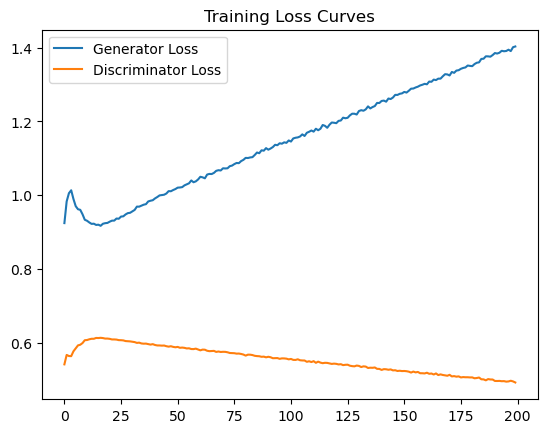

C:\Users\SIVAKUMAR S\anaconda3\envs\pytorchgpu\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\SIVAKUMAR S\anaconda3\envs\pytorchgpu\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


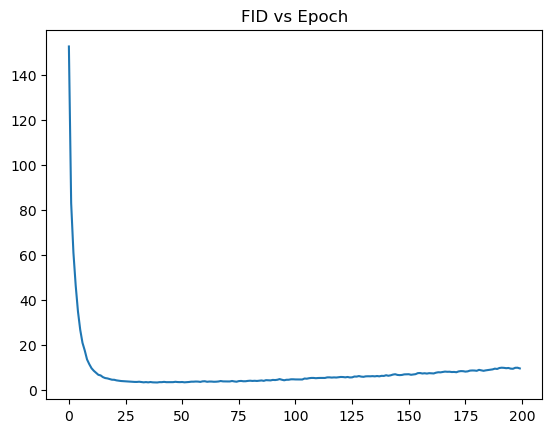

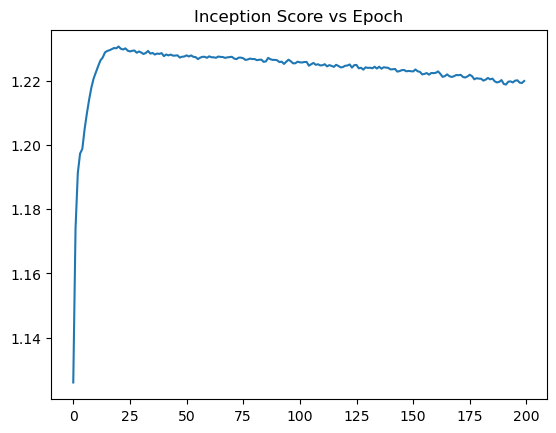

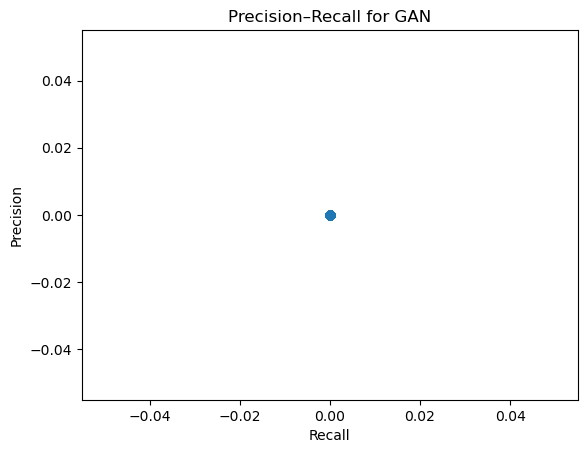

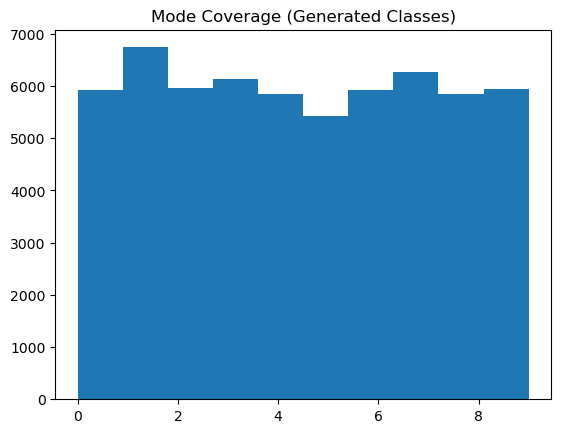

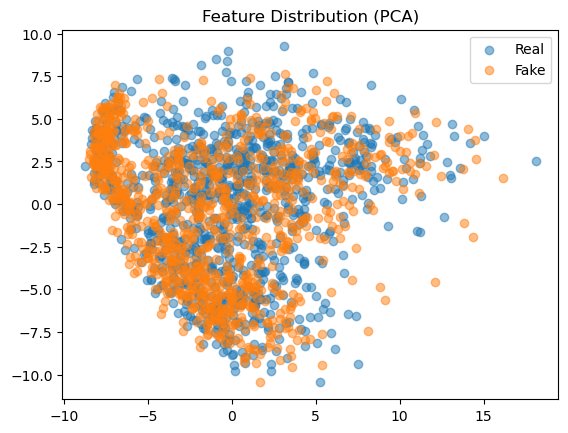

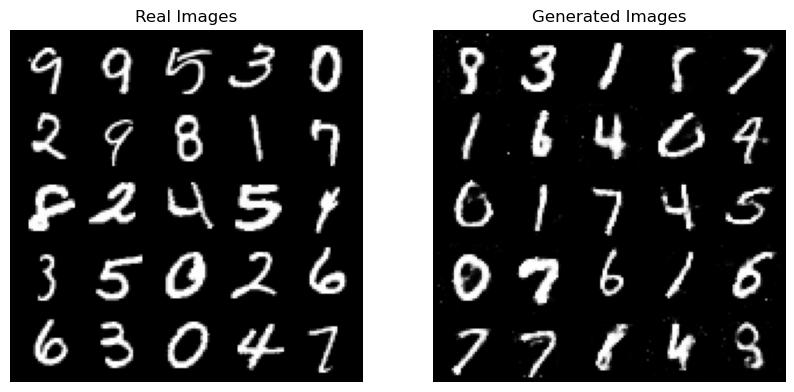

In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm

# -----------------------------
# Configuration
# -----------------------------
class Opt:
    n_epochs = 200
    batch_size = 64
    lr = 0.0002
    b1 = 0.5
    b2 = 0.999
    latent_dim = 100
    img_size = 28
    channels = 1
    sample_interval = 500

opt = Opt()

img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

os.makedirs("images", exist_ok=True)

# -----------------------------
# Generator
# -----------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(opt.latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), *img_shape)

# -----------------------------
# Discriminator
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

# -----------------------------
# Initialize
# -----------------------------
adversarial_loss = nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# -----------------------------
# Dataset
# -----------------------------
dataloader = DataLoader(
    datasets.MNIST(
        "./data",
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    ),
    batch_size=opt.batch_size,
    shuffle=True
)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# -----------------------------
# Metric storage
# -----------------------------
G_losses, D_losses = [], []
FID_scores, IS_scores = [], []
precisions, recalls = [], []

# -----------------------------
# Helper functions
# -----------------------------
def compute_fid(real, fake):
    mu1, sigma1 = real.mean(0), np.cov(real, rowvar=False)
    mu2, sigma2 = fake.mean(0), np.cov(fake, rowvar=False)
    covmean = sqrtm(sigma1 @ sigma2)
    return np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)

def inception_score(probs):
    py = np.mean(probs, axis=0)
    kl = probs * (np.log(probs + 1e-8) - np.log(py + 1e-8))
    return np.exp(np.mean(np.sum(kl, axis=1)))

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(opt.n_epochs):

    g_epoch, d_epoch = 0, 0
    real_feats, fake_feats = [], []
    fake_labels = []

    for imgs, labels in dataloader:

        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0))
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0))
        real_imgs = Variable(imgs.type(Tensor))

        # Generator
        optimizer_G.zero_grad()
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.size(0), opt.latent_dim))))
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        g_epoch += g_loss.item()
        d_epoch += d_loss.item()

        real_feats.append(real_imgs.view(imgs.size(0), -1).cpu().numpy())
        fake_feats.append(gen_imgs.view(imgs.size(0), -1).cpu().detach().numpy())
        fake_labels.append(labels.numpy())

    # Average losses
    G_losses.append(g_epoch / len(dataloader))
    D_losses.append(d_epoch / len(dataloader))

    real_feats = np.vstack(real_feats)
    fake_feats = np.vstack(fake_feats)

    # FID
    fid = compute_fid(real_feats, fake_feats)
    FID_scores.append(fid)

    # IS (proxy)
    probs = np.exp(fake_feats) / np.sum(np.exp(fake_feats), axis=1, keepdims=True)
    IS_scores.append(inception_score(probs))

    # Precision / Recall (proxy)
    precision = np.mean(np.linalg.norm(fake_feats - real_feats.mean(0), axis=1) < 5)
    recall = np.mean(np.linalg.norm(real_feats - fake_feats.mean(0), axis=1) < 5)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Epoch {epoch+1}/{opt.n_epochs} | G: {G_losses[-1]:.4f} | D: {D_losses[-1]:.4f} | FID: {fid:.2f}")

    # Save sample images
    save_image(gen_imgs[:25], f"images/fake_epoch_{epoch}.png", nrow=5, normalize=True)
    save_image(real_imgs[:25], f"images/real_epoch_{epoch}.png", nrow=5, normalize=True)

# -----------------------------
# VISUALIZATIONS
# -----------------------------

# 1. Loss Curves
plt.figure()
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.legend()
plt.title("Training Loss Curves")
plt.show()

# 2. FID vs Epoch
plt.figure()
plt.plot(FID_scores)
plt.title("FID vs Epoch")
plt.show()

# 3. IS vs Epoch
plt.figure()
plt.plot(IS_scores)
plt.title("Inception Score vs Epoch")
plt.show()

# 4. Precision–Recall Curve
plt.figure()
plt.plot(recalls, precisions, marker='o')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall for GAN")
plt.show()

# 5. Mode Coverage
plt.figure()
plt.hist(np.concatenate(fake_labels), bins=10)
plt.title("Mode Coverage (Generated Classes)")
plt.show()

# 6. Feature Similarity (PCA)
pca = PCA(2)
real_pca = pca.fit_transform(real_feats[:1000])
fake_pca = pca.transform(fake_feats[:1000])

plt.figure()
plt.scatter(real_pca[:,0], real_pca[:,1], alpha=0.5, label="Real")
plt.scatter(fake_pca[:,0], fake_pca[:,1], alpha=0.5, label="Fake")
plt.legend()
plt.title("Feature Distribution (PCA)")
plt.show()

# 7. Real vs Fake Image Comparison
real_grid = make_grid(real_imgs[:25], nrow=5, normalize=True)
fake_grid = make_grid(gen_imgs[:25], nrow=5, normalize=True)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(real_grid.permute(1,2,0).cpu())
plt.title("Real Images")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(fake_grid.permute(1,2,0).cpu())
plt.title("Generated Images")
plt.axis("off")
plt.show()
